In [484]:
import numpy as np
import cv2, math
from matplotlib import pyplot as plt

In [485]:
"""
Author: Kavindu Chamith
Date: 23/09/2021
Description: Fourier Transformation
            (Gaussian filter, Laplacian filter and 
            periodic noise removal in Fourier domain)
"""

'\nAuthor: Kavindu Chamith\nDate: 23/09/2021\nDescription: Fourier Transformation\n            (Gaussian filter, Laplacian filter and \n            periodic noise removal in Fourier domain)\n'

In [486]:
# helper function for diplaying images
def showImages(imgs, names, width=10, height=10):
    # changing the size of canvas
    plt.rcParams['figure.figsize'] = [width, height] 

    plot = 130
    for i in range(len(imgs)):
        plot += 1
        plt.subplot(plot), plt.imshow(imgs[i], cmap='gray'), plt.title(names[i])
    plt.tight_layout()
    plt.show()


In [487]:
# function for creating a Laplacian mask for fourier domain
def laplacianMask(shape, isComplex):
    # isComplex value checks if the mask is created to deal with complex values, 
    # then we have to have 2 planes
    if isComplex:
        # mask with 2 planes because we have real and imaginary values in filter
        mask = np.zeros((shape[0], shape[1], 2), dtype='float32')
    else: 
        mask = np.zeros(shape, dtype='float32')

    M = shape[0] # rows
    N = shape[1] # cols

    for i in range(M):
        for j in range(N):
            mask[i][j] = -((i-M/2)**2 + (j-N/2)**2) 
    return mask

In [488]:
# function for creating a ideal highpass filter mask for given D value
def idealHighpassFilter(shape, D):
    mask = np.zeros(shape, dtype='float32')
    M = shape[0] # rows
    N = shape[1] # cols
    
    for i in range(M):
        for j in range(N):
            mask[i][j] = 1 if math.sqrt((i-M/2)**2 + (j-N/2)**2) >= D else 0 
    return mask

In [489]:
# function for creating a gausssian lowpass filter mask for given D value
def gaussianLowpass(shape, D):
    mask = np.zeros(shape, dtype='float32')
    M = shape[0] # rows
    N = shape[1] # cols
    
    for i in range(M):
        for j in range(N):
            d = math.sqrt((i-M/2)**2 + (j-N/2)**2)
            mask[i][j] = np.exp(-((d*d)/(2*D*D)))
    return mask

In [490]:
# function for creating a notch filter 
def notchFilter(shape, M1, N1, M2, N2, M3, N3, D):
    mask = np.zeros(shape, dtype='float32')
    rows = shape[0]
    cols = shape[1]
    val = 0
    for i in range(rows):
        for j in range(cols):
            if (math.sqrt(abs(i-M1)**2 + abs(j-N1)**2) <= D ):
                mask[i][j] = val

            elif (math.sqrt(abs(i-M2)**2 + abs(j-N2)**2) <= D):
                mask[i][j] = val

            elif (math.sqrt(abs(i-M1)**2 + abs(j-cols+N1)**2) <= D): 
                mask[i][j] = val

            elif (math.sqrt(abs(i-rows+M2)**2 + abs(j-N2)**2) <= D):
                mask[i][j] = val

            elif(math.sqrt(abs(i-M3)**2 + abs(j-N3)**2) <= D):
                mask[i][j] = val

            elif(math.sqrt(abs(i-M3)**2 + abs(j-cols+N3)**2) <= D):
                mask[i][j] = val

            elif(math.sqrt(abs(i-rows+M3)**2 + abs(j-N3)**2) <= D):
                mask[i][j] = val

            elif (math.sqrt(abs(i-rows+M3)**2 + abs(j-cols+N3)**2) <= D):
                mask[i][j] = val

            else: 
                mask[i][j] = 1-val
    return mask


In [491]:
if __name__ == '__main__':
    img = cv2.imread('car.jpg',0) # read the image
    img_float32 = np.float32(img)

In [492]:
    """ Question 1 """
    
    # discreate fourier transform
    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT) 
    # shift the zero freq components
    dft_shift = np.fft.fftshift(dft)

In [493]:
    mask = laplacianMask(img.shape, True)
    # calculate magnitude of complex values
    mask_to_display = cv2.magnitude(mask[:,:,0],mask[:,:,1])
    # normalize mask values to 0-255 range to display
    mask_to_display = cv2.normalize(mask_to_display, None, 0, 255, cv2.NORM_MINMAX)
    # apply mask and inverse DFT
    fshift = dft_shift * mask

    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift) 
    
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
    # normalize values back to 0-255 range
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)

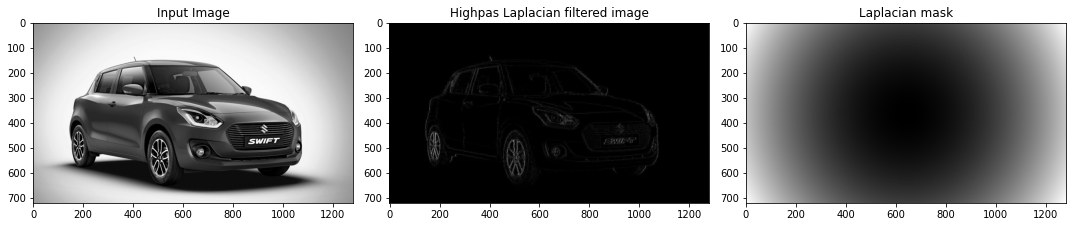

In [494]:
    showImages([img, img_back, mask_to_display], ['Input Image', 'Highpas Laplacian filtered image', 'Laplacian mask'], 15, 5)

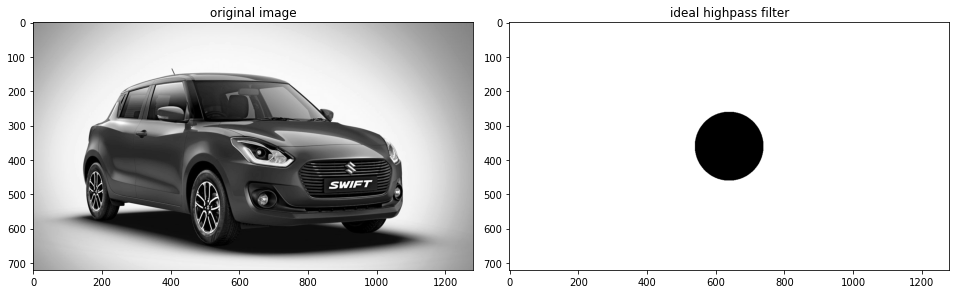

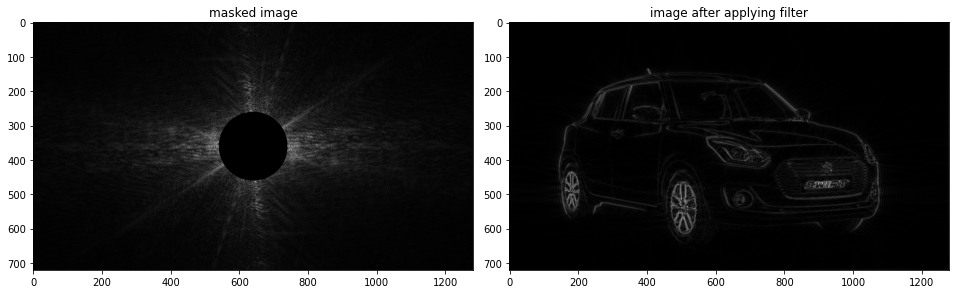

In [495]:
    """ Question 2"""

    f = np.fft.fft2(img) # fast fourier transform
    fshift = np.fft.fftshift(f) # shift zero freq components to center

    # creating a ideal highpassfilter mask with D=100
    mask = idealHighpassFilter(img.shape, 100)

    # applying the mask
    masked = fshift * mask

    # taking magnitude of result
    mask_spectrum = np.abs(masked)
    # normalize into 0-255 range
    mask_spectrum = cv2.normalize(mask_spectrum, None, 0, 255, cv2.NORM_MINMAX)

    # shift back the zero freq components
    f_ishift = np.fft.ifftshift(masked)
    img_back = np.fft.ifft2(f_ishift) # inverse fast fourier transform
    img_back = np.abs(img_back) # taking magnitude of image to display

    showImages([img, mask], ['original image', 'ideal highpass filter'], 20, 10)
    showImages([mask_spectrum, img_back], ['masked image', 'image after applying filter'], 20, 10)


In [496]:
    """ Question 3"""

    f = np.fft.fft2(img) # fast fourier transform
    fshift = np.fft.fftshift(f) # shift zero freq components to center
    
    fft2_spectrum = 20*np.log(np.abs(f))
    inv_fft2_spectrum = np.abs(np.fft.ifft2(f))

In [497]:
    gaussmask = gaussianLowpass(img.shape, 20)
    # applying the mask
    masked = fshift * gaussmask

    # shift back the zero freq components
    f_ishift = np.fft.ifftshift(masked)
    gauss_img_back = np.fft.ifft2(f_ishift) # inverse fast fourier transform
    gauss_img_back = np.abs(gauss_img_back) # taking magnitude of image to display

In [498]:
    # creating a laplacian mask
    lapmask = laplacianMask(img.shape, False)

    # applying the mask
    masked = fshift * abs(lapmask)

    # shift back the zero freq components
    f_ishift = np.fft.ifftshift(masked)
    lap_img_back = np.fft.ifft2(f_ishift) # inverse fast fourier transform
    lap_img_back = np.abs(lap_img_back) # taking magnitude of image to display


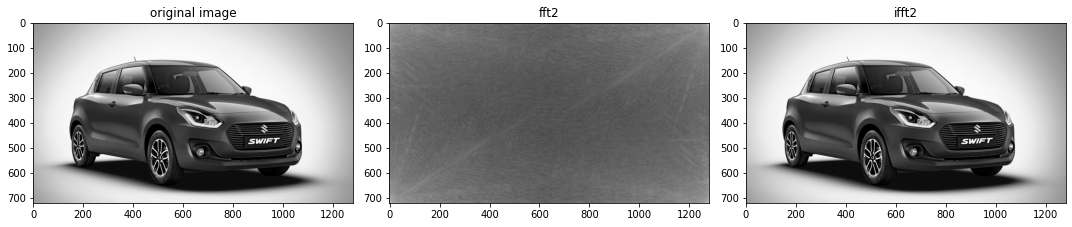

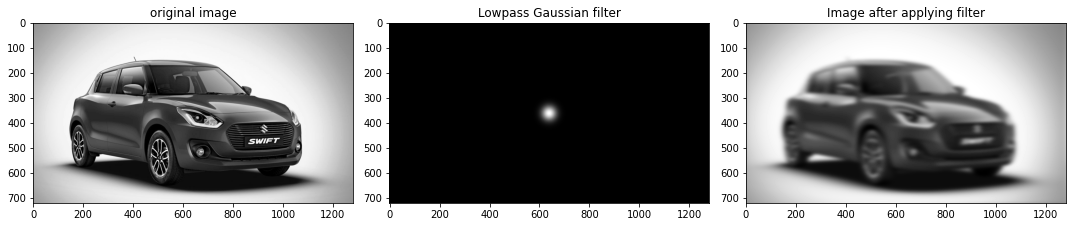

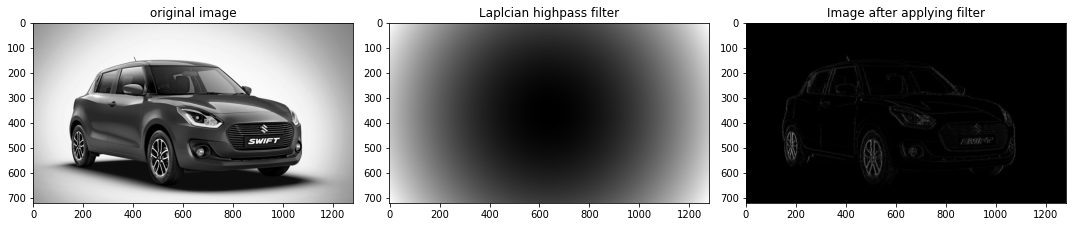

In [499]:
    width = 15
    height = 5
    showImages([img, fft2_spectrum, inv_fft2_spectrum], ['original image', 'fft2', 'ifft2'], width, height)
    showImages([img, gaussmask, gauss_img_back], ['original image', 'Lowpass Gaussian filter', 'Image after applying filter'], width, height)
    showImages([img, abs(lapmask), lap_img_back], ['original image', 'Laplcian highpass filter', 'Image after applying filter'], width, height)

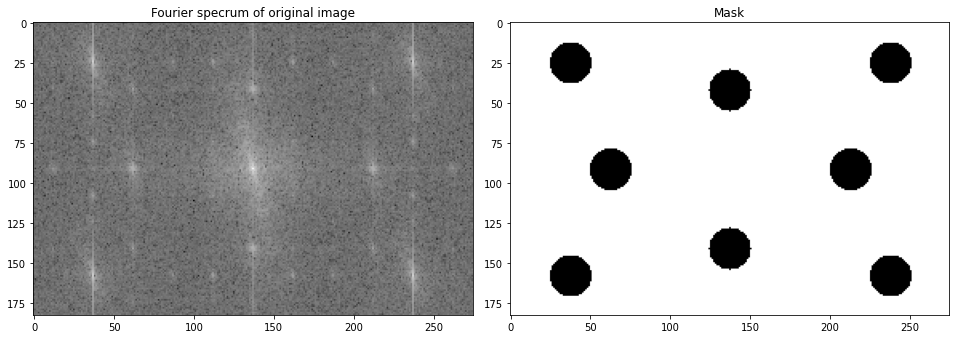

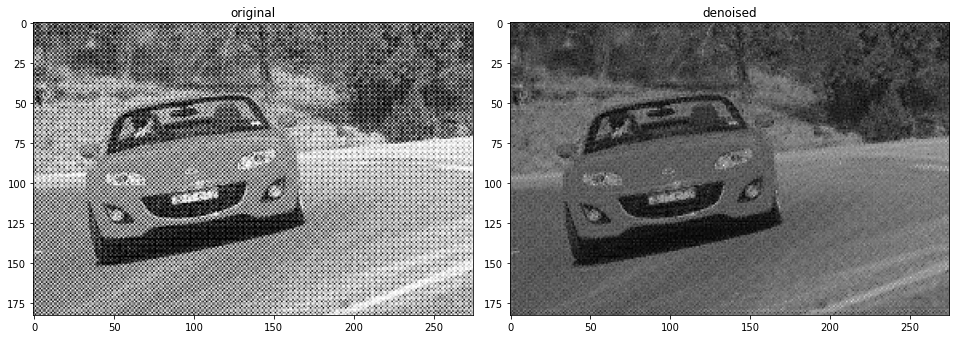

In [500]:
    """ Question 4 """
    noise_car = cv2.imread('car-2.jpg', 0)
    
    f = np.fft.fft2(noise_car) # fast fourier transform
    fshift = np.fft.fftshift(f) # shift zero freq components to center
    
    fft2_spectrum = 20*np.log(np.abs(fshift))

    # creating a notch filter
    mask = notchFilter(noise_car.shape, 91.5, 212.5, 42, 137, 25, 237.5, 13)

    #applying mask
    result = fshift * mask
    
    # shift back the zero freq components
    f_ishift = np.fft.ifftshift(result)
    denoised = np.fft.ifft2(f_ishift) # inverse fast fourier transform
    denoised = np.abs(denoised) # taking magnitude of image to display
    
    # normalize into 0-255 range
    denoised = cv2.normalize(denoised, None, 0, 255, cv2.NORM_MINMAX)

    showImages([fft2_spectrum, mask], ['Fourier specrum of original image', 'Mask'], 20,20)
    showImages([noise_car, denoised], ['original', 'denoised'], 20, 20)